In [66]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zalando-research/fashionmnist")

print("Path to dataset files:", path)

C:\Users\seher\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|█████████████████████████████████████████████████████████████████████████████| 68.8M/68.8M [00:56<00:00, 1.27MB/s]

Extracting files...


Path to dataset files: C:\Users\seher\.cache\kagglehub\datasets\zalando-research\fashionmnist\versions\4


In [ ]:
pip update kagglehub

In [146]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import FashionMNIST
from sklearn.model_selection import train_test_split

dataset_path = './data'  

# Pre-processing transformations
transform = transforms.Compose([
    transforms.ToTensor(),                       
    transforms.Normalize((0.5,), (0.5,))         
])

# Load the FashionMNIST dataset
dataset = FashionMNIST(root=dataset_path, train=True, download=True, transform=transform)

# Extract labels to perform stratified splits
labels = torch.tensor([item[1] for item in dataset])

# Split into training, validation, and test sets
train_indices, temp_indices = train_test_split(
    range(len(labels)), test_size=0.25, stratify=labels.numpy(), random_state=42
)
val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5, stratify=labels.numpy()[temp_indices], random_state=42
)

# Reduce the size of the splits to match the requirement
train_indices = train_indices[:200]  
val_indices = val_indices[:100]      
test_indices = test_indices[:50]     

# Create subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Summary of splits
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


100%|██████████████████████████████████████████████████████████████████████████████| 26.4M/26.4M [03:06<00:00, 142kB/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 209kB/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████| 4.42M/4.42M [00:41<00:00, 106kB/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|█████████████████████████████████████████████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 1.15MB/s]


Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw

Training samples: 200
Validation samples: 100
Test samples: 50


In [176]:
import pennylane as qml
import torch.nn as nn

# Define the number of qubits 
n_qubits = 9
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the quantum circuit (encoding + convolutional layer)
@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs):
    # Encoding: Use rotation gates based on input data
    for i in range(n_qubits):
        qml.RX(inputs[i], wires=i)

    # Random Quantum Circuit 
    for _ in range(2):  # Increase the depth by repeating
        for i in range(n_qubits):
            qml.RY(np.random.rand() * np.pi, wires=i)  # Random rotations
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])

    # Measure the expectation values of each qubit
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
    

# Quantum layer in PyTorch
class QuantumLayer(nn.Module):
    def __init__(self):
        super(QuantumLayer, self).__init__()
        # Define quantum circuit using Pennylane
        self.qnode = qml.QNode(quantum_circuit, dev, interface="torch")

    def forward(self, x):
        # Ensure input features match the number of qubits
        assert x.shape[1] == n_qubits, "Input features must match the number of qubits"
        
        # Apply the quantum circuit to each data sample
        quantum_outputs = []
        for sample in x:
            # Convert the sample to a NumPy array if necessary
            sample_numpy = sample.detach().cpu().numpy()
            # Evaluate the QNode and convert the result back to a PyTorch tensor
            output = torch.tensor(self.qnode(sample_numpy), dtype=torch.float32, device=x.device)
            quantum_outputs.append(output)

        # Stack the results into a tensor
        return torch.stack(quantum_outputs)



In [156]:
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

class QuantumCNN(nn.Module):
    def __init__(self):
        super(QuantumCNN, self).__init__()
        # Classical Convolutional Layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # 32 filters
        self.pool1 = nn.MaxPool2d(2, 2)  # Downsample

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # 64 filters
        self.pool2 = nn.MaxPool2d(2, 2)  # Downsample

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # 128 filters
        self.pool3 = nn.MaxPool2d(2, 2)  # Downsample
        
        # Fully connected to reduce to `n_qubits`
        self.reduce_to_qubits = nn.Linear(128 * 3 * 3, n_qubits)  # Adjust input size

        # Quantum layer
        self.quantum_layer = QuantumLayer()

        # Classification layer
        self.fc_output = nn.Linear(n_qubits, 10)

    def forward(self, x):
        # Classical Convolutional Layers
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        # Flatten the output
        x = x.view(-1, 128 * 3 * 3)
        print(f"Shape before quantum layer: {x.shape}")
        
        # Fully Connected Layer before Quantum Layer
        x = F.relu(self.reduce_to_qubits(x))

        # Quantum Layer
        x = self.quantum_layer(x)
        print(f"Shape after quantum layer: {x.shape}")

        # Fully connected classification layer
        x = torch.softmax(self.fc_output(x), dim=1)
        return x


# Initialize the model
model = QuantumCNN()
inputs = torch.rand(n_qubits)  # Random tensor of size n_qubits
quantum_output = quantum_circuit(inputs)
print(f"Quantum circuit output shape: {len(quantum_output)}")

for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    print(f"Output shape: {outputs.shape}")
    break


Quantum circuit output shape: 9
Shape before quantum layer: torch.Size([32, 1152])
Shape after quantum layer: torch.Size([32, 9])
Output shape: torch.Size([32, 10])


In [6]:
import pennylane as qml
from pennylane import numpy as np
from qiskit.circuit import ParameterVector
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap
import matplotlib.pyplot as plt

# Example of using the Pennylane's drawing tool
inputs = np.random.rand(n_qubits)
print(qml.draw(quantum_circuit)(inputs))  # Pennylane visualization

# Define a Qiskit circuit for visualization
params = ParameterVector("θ", length=n_qubits)
qiskit_circuit = QuantumCircuit(n_qubits)

# Add parameterized RX gates
for i in range(n_qubits):
    qiskit_circuit.rx(params[i], i)

# Add CNOT gates
for i in range(n_qubits - 1):
    qiskit_circuit.cx(i, i + 1)

# Draw the Qiskit circuit
qiskit_circuit.draw("mpl", style="Clifford")
plt.show()


0: ──RX(0.78)──RY(1.42)─╭●──RY(1.46)───────────╭●───────────────────────────────────────────────
1: ──RX(0.31)──RY(2.90)─╰X─╭●─────────RY(2.30)─╰X────────╭●─────────────────────────────────────
2: ──RX(0.46)──RY(0.75)────╰X────────╭●─────────RY(2.42)─╰X────────╭●───────────────────────────
3: ──RX(0.19)──RY(1.33)──────────────╰X────────╭●─────────RY(1.16)─╰X────────╭●─────────────────
4: ──RX(0.53)──RY(1.15)────────────────────────╰X────────╭●─────────RY(1.85)─╰X────────╭●───────
5: ──RX(0.05)──RY(2.75)──────────────────────────────────╰X────────╭●─────────RY(0.11)─╰X───────
6: ──RX(0.96)──RY(2.30)────────────────────────────────────────────╰X────────╭●─────────RY(0.58)
7: ──RX(0.22)──RY(1.89)──────────────────────────────────────────────────────╰X────────╭●───────
8: ──RX(0.44)──RY(1.88)────────────────────────────────────────────────────────────────╰X───────

──────────────────┤  <Z>
──────────────────┤  <Z>
──────────────────┤  <Z>
──────────────────┤  <Z>
──────────────────┤  <Z>
─

Shape before quantum layer: torch.Size([32, 1152])
Shape after quantum layer: torch.Size([32, 9])
Shape before quantum layer: torch.Size([32, 1152])
Shape after quantum layer: torch.Size([32, 9])
Shape before quantum layer: torch.Size([32, 1152])
Shape after quantum layer: torch.Size([32, 9])
Shape before quantum layer: torch.Size([32, 1152])
Shape after quantum layer: torch.Size([32, 9])
Shape before quantum layer: torch.Size([32, 1152])
Shape after quantum layer: torch.Size([32, 9])
Shape before quantum layer: torch.Size([32, 1152])
Shape after quantum layer: torch.Size([32, 9])
Shape before quantum layer: torch.Size([8, 1152])
Shape after quantum layer: torch.Size([8, 9])
Shape before quantum layer: torch.Size([32, 1152])
Shape after quantum layer: torch.Size([32, 9])
Shape before quantum layer: torch.Size([32, 1152])
Shape after quantum layer: torch.Size([32, 9])
Shape before quantum layer: torch.Size([32, 1152])
Shape after quantum layer: torch.Size([32, 9])
Shape before quantum l

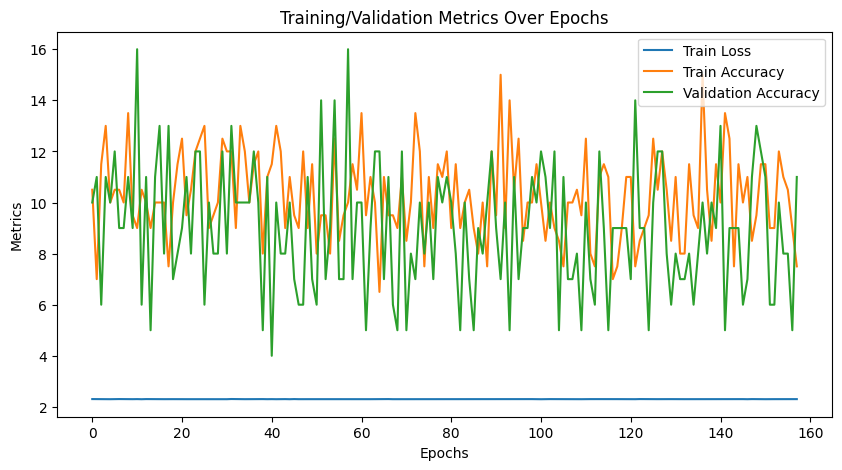

In [186]:
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
from sklearn.metrics import classification_report

# Send model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training setup
# Calculate weights for each class
class_counts = np.bincount([label for _, label in train_dataset])
weights = 1.0 / (class_counts + 1e-6)
weights = torch.tensor(weights, dtype=torch.float32, device=device)

# Use the weights in CrossEntropyLoss
criterion = CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping setup
patience = 100  # Number of epochs to wait before stopping
best_val_accuracy = 0
early_stop_counter = 0

# Store training/validation metrics
train_loss_values = []
train_accuracy_values = []
val_accuracy_values = []

# Training loop
num_epochs = 400
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Calculate training metrics
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_loss_values.append(train_loss)
    train_accuracy_values.append(train_accuracy)

    # Validation phase
    model.eval()
    correct_val = 0
    total_val = 0
    all_val_labels = []
    all_val_predictions = []
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            _, val_predicted = torch.max(val_outputs, 1)

            correct_val += (val_predicted == val_labels).sum().item()
            total_val += val_labels.size(0)
            all_val_labels.extend(val_labels.cpu().numpy())
            all_val_predictions.extend(val_predicted.cpu().numpy())

    # Calculate and store validation accuracy
    val_accuracy = 100 * correct_val / total_val
    val_accuracy_values.append(val_accuracy)

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Acc: {val_accuracy:.2f}%")

    # Classification report (optional)
    if (epoch + 1) % 10 == 0 or epoch == num_epochs - 1:
        print("\nValidation Metrics:")
        print(classification_report(all_val_labels, all_val_predictions, zero_division=1))

    # Early stopping check
    if val_accuracy >= best_val_accuracy:
        best_val_accuracy = val_accuracy
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Plot training/validation metrics
plt.figure(figsize=(10, 5))
plt.plot(train_loss_values, label="Train Loss")
plt.plot(train_accuracy_values, label="Train Accuracy")
plt.plot(val_accuracy_values, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.legend()
plt.title("Training/Validation Metrics Over Epochs")
plt.show()


In [188]:

correct_test = 0
total_test = 0
all_test_labels = []
all_test_predictions = []

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        _, test_predicted = torch.max(test_outputs, 1)

        correct_test += (test_predicted == test_labels).sum().item()
        total_test += test_labels.size(0)
        all_test_labels.extend(test_labels.cpu().numpy())
        all_test_predictions.extend(test_predicted.cpu().numpy())

test_accuracy = 100 * correct_test / total_test
print(f"Test Accuracy: {test_accuracy:.2f}%")


Shape before quantum layer: torch.Size([1, 1152])
Shape after quantum layer: torch.Size([1, 9])
Shape before quantum layer: torch.Size([1, 1152])
Shape after quantum layer: torch.Size([1, 9])
Shape before quantum layer: torch.Size([1, 1152])
Shape after quantum layer: torch.Size([1, 9])
Shape before quantum layer: torch.Size([1, 1152])
Shape after quantum layer: torch.Size([1, 9])
Shape before quantum layer: torch.Size([1, 1152])
Shape after quantum layer: torch.Size([1, 9])
Shape before quantum layer: torch.Size([1, 1152])
Shape after quantum layer: torch.Size([1, 9])
Shape before quantum layer: torch.Size([1, 1152])
Shape after quantum layer: torch.Size([1, 9])
Shape before quantum layer: torch.Size([1, 1152])
Shape after quantum layer: torch.Size([1, 9])
Shape before quantum layer: torch.Size([1, 1152])
Shape after quantum layer: torch.Size([1, 9])
Shape before quantum layer: torch.Size([1, 1152])
Shape after quantum layer: torch.Size([1, 9])
Shape before quantum layer: torch.Size([

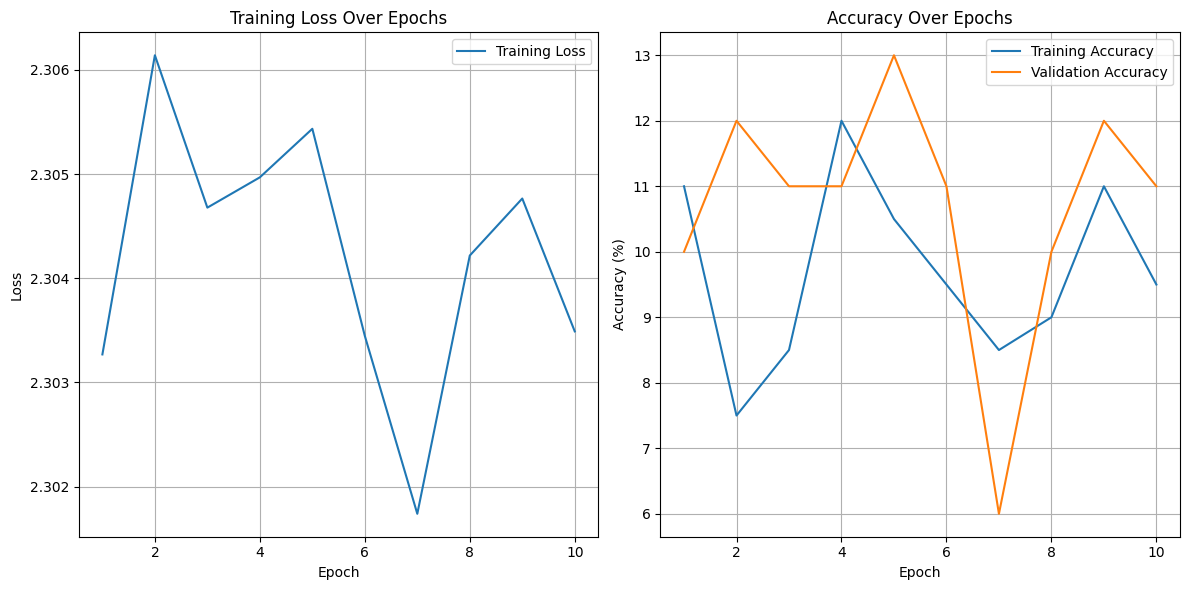

In [160]:
# Plot the training and validation metrics
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_values, marker='', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracy_values, marker='', label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracy_values, marker='', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
print(f"Number of classes: {len(set(labels))}")
for inputs, labels in train_loader:
    print(f"Batch labels: {labels}")
    break
print(f"Output layer size: {model.fc_output.out_features}")
max_label = max([max(labels.tolist()) for _, labels in train_loader])
print(f"Max label in dataset: {max_label}")

In [174]:
import torchvision.transforms as transforms
from PIL import Image

# Load a sample image and apply the same transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Example: Replace "sample_image_path" with your test image path
sample_image_path = "shirt-modified.jpeg"
sample_image = Image.open(sample_image_path)
input_tensor = transform(sample_image).unsqueeze(0).to(device)  # Add batch dimension

# Model inference
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    predicted_class = torch.argmax(output, dim=1).item()

# Decode the class label
class_labels = train_dataset.dataset.classes  # Retrieve class names
predicted_label = class_labels[predicted_class]

print(f"Predicted Class: {predicted_label}")


Shape before quantum layer: torch.Size([1, 1152])
Shape after quantum layer: torch.Size([1, 9])
Predicted Class: T-shirt/top


In [190]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
import numpy as np

# Ensure your model is in evaluation mode
model.eval()

# Placeholder for predictions and true labels
all_predictions = []
all_true_labels = []

# Run inference on the test set
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move data to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Perform inference
        outputs = model(inputs)
        
        predicted = torch.argmax(outputs, dim=1)

        # Collect predictions and true labels
        all_predictions.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

# Convert to NumPy arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

# Compute metrics
accuracy = accuracy_score(all_true_labels, all_predictions)
precision = precision_score(all_true_labels, all_predictions, average='weighted', zero_division=1)
recall = recall_score(all_true_labels, all_predictions, average='weighted', zero_division=1)
f1 = f1_score(all_true_labels, all_predictions, average='weighted', zero_division=1)


# Print results
print("Predictions:", all_predictions)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

from collections import Counter

print("True label distribution:", Counter(all_true_labels))
print("Predicted label distribution:", Counter(all_predictions))



Shape before quantum layer: torch.Size([1, 1152])
Shape after quantum layer: torch.Size([1, 9])
Shape before quantum layer: torch.Size([1, 1152])
Shape after quantum layer: torch.Size([1, 9])
Shape before quantum layer: torch.Size([1, 1152])
Shape after quantum layer: torch.Size([1, 9])
Shape before quantum layer: torch.Size([1, 1152])
Shape after quantum layer: torch.Size([1, 9])
Shape before quantum layer: torch.Size([1, 1152])
Shape after quantum layer: torch.Size([1, 9])
Shape before quantum layer: torch.Size([1, 1152])
Shape after quantum layer: torch.Size([1, 9])
Shape before quantum layer: torch.Size([1, 1152])
Shape after quantum layer: torch.Size([1, 9])
Shape before quantum layer: torch.Size([1, 1152])
Shape after quantum layer: torch.Size([1, 9])
Shape before quantum layer: torch.Size([1, 1152])
Shape after quantum layer: torch.Size([1, 9])
Shape before quantum layer: torch.Size([1, 1152])
Shape after quantum layer: torch.Size([1, 9])
Shape before quantum layer: torch.Size([